# 최소성취수준 보장지도(최성보) 위험군 조기 예측 — EDA

본 노트북은 정보·컴퓨터 교과에서 **최소성취수준 보장지도 대상 학생을 학기 중간 시점에 사전 예측**하기 위한 베이스라인 탐색적 데이터 분석(EDA)을 수행한다.

---

## 1. 분석 목적

- 학기 종료 후 확정되는 성취율이 아닌  
  **학기 중간 시점 데이터만으로 위험군을 사전 탐지**하는 것이 목적이다.
- 교사는 예방지도를 위한 예비군을 선별해야 하며,  
  본 분석은 그 선별 기준을 데이터 기반으로 도출하는 데 초점을 둔다.

---

## 2. 예측 시나리오

입력 데이터는 다음과 같은 **학기 중간 스냅샷 CSV**를 가정한다.

- 중간고사 성적
- 수행평가 일부 점수
- 과제 제출 횟수
- 수업 참여도
- 질문 횟수
- 결석 횟수
- 상벌점
- 야간자율학습 참여 여부

기말고사 점수는 존재하지 않을 수 있으며,  
성취율 계산 시 사용 가능한 점수만 반영한다.

---

## 3. 타겟 정의

최종 라벨은 다음 기준으로 생성된다.

- 성취율 < 40%
- 또는 결석률 ≥ 1/3

→ 최소성취수준 보장지도 대상(최성보)

---

## 4. 분석 범위

본 노트북에서 수행하는 분석:

1. 데이터 구조 및 품질 점검
2. 결측 데이터 영향 분석
3. 위험군 분포 확인
4. 변수별 위험군 차이 분석
5. 위험군 조기 탐지 후보 변수 도출

---

## 5. 활용 목적

본 EDA 결과는 이후 단계에서:

- 위험군 분류 모델 학습
- 예측 정확도 평가
- 예방지도 대상 자동 선별

시스템 구축의 기초 자료로 활용된다.

## 환경/경로 세팅 + 모듈 import

In [1]:
# --- path setup (src import) ---
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent  # notebook/ 기준 상위가 프로젝트 루트
sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)
print("PYTHONPATH[0]:", sys.path[0])

# --- imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.preprocessing import load_csv, preprocess_pipeline


PROJECT_ROOT: d:\workSpace\edutech-risk-prediction
PYTHONPATH[0]: d:\workSpace\edutech-risk-prediction


## 더미 데이터 로드 + 전처리 + 라벨 생성

In [2]:
# 데이터 로드
df_full_raw = load_csv("../data/dummy/dummy_full.csv")
df_mid_raw  = load_csv("../data/dummy/dummy_midterm_like.csv")

print("raw shapes:", df_full_raw.shape, df_mid_raw.shape)

# 전처리 + 성취율/위험군 라벨 생성
df_full = preprocess_pipeline(df_full_raw, add_labels=True)
df_mid  = preprocess_pipeline(df_mid_raw,  add_labels=True)

# 핵심 확인
display(df_full.head())
display(df_mid.head())

print("\nmissing(final_score)")
print("full:", df_full_raw["final_score"].isna().sum())
print("mid :", df_mid_raw["final_score"].isna().sum())

print("\nrisk rate (at_risk=1)")
print("full:", round(df_full["at_risk"].mean(), 3))
print("mid :", round(df_mid["at_risk"].mean(), 3))


raw shapes: (300, 11) (300, 11)


,student_id,midterm_score,final_score,performance_score,assignment_count,participation_level,question_count,night_study,absence_count,behavior_score,at_risk,participation_level_num,achievement_rate
0,S0001,53.159702,31.942077,19.320596,6.0,중,2.0,1,4.5,2.0,1,1,34.8
1,S0002,24.207081,37.670460,54.037913,8.0,중,1.0,1,3.0,2.0,1,1,38.6
2,S0003,60.554272,61.234848,32.656957,9.0,중,3.0,1,5.0,4.0,0,1,51.5
3,S0004,40.754560,21.575097,26.181722,9.0,하,3.0,0,5.0,4.0,1,0,29.5
4,S0005,58.265514,64.316524,55.088438,10.0,상,4.0,1,0.0,3.0,0,2,59.2


,student_id,midterm_score,final_score,performance_score,assignment_count,participation_level,question_count,night_study,absence_count,behavior_score,at_risk,participation_level_num,achievement_rate
0,S0001,53.159702,0.0,19.320596,6.0,중,2.0,1,4.5,2.0,1,1,24.2
1,S0002,24.207081,0.0,54.037913,8.0,중,1.0,1,3.0,2.0,1,1,26.1
2,S0003,60.554272,0.0,32.656957,9.0,중,3.0,1,5.0,4.0,1,1,31.1
3,S0004,40.754560,0.0,26.181722,9.0,하,3.0,0,5.0,4.0,1,0,22.3
4,S0005,58.265514,0.0,55.088438,10.0,상,4.0,1,0.0,3.0,1,2,37.8



missing(final_score)
full: 0
mid : 300

risk rate (at_risk=1)
full: 0.507
mid : 0.883


## 데이터 품질 점검 + 요약 테이블 저장

In [3]:
from pathlib import Path

TAB_DIR = Path("../reports/tables")
TAB_DIR.mkdir(parents=True, exist_ok=True)

def quality_report(df: pd.DataFrame, name: str) -> pd.DataFrame:
    out = pd.DataFrame({
        "column": df.columns,
        "dtype": [str(df[c].dtype) for c in df.columns],
        "missing": [int(df[c].isna().sum()) for c in df.columns],
        "missing_rate": [float(df[c].isna().mean()) for c in df.columns],
        "n_unique": [int(df[c].nunique(dropna=True)) for c in df.columns],
    })
    out["dataset"] = name
    return out[["dataset","column","dtype","missing","missing_rate","n_unique"]]

qr_full = quality_report(df_full_raw, "dummy_full_raw")
qr_mid  = quality_report(df_mid_raw,  "dummy_midterm_like_raw")

quality = pd.concat([qr_full, qr_mid], ignore_index=True)

display(quality.sort_values(["dataset","missing_rate","column"], ascending=[True, False, True]).head(30))

# 저장
quality_path = TAB_DIR / "data_quality_report.csv"
quality.to_csv(quality_path, index=False, encoding="utf-8-sig")
print("saved:", quality_path)

# 추가: 숫자 요약 통계(전처리 후)
desc_full = df_full.describe(include="all").T
desc_mid  = df_mid.describe(include="all").T

desc_full_path = TAB_DIR / "desc_dummy_full_processed.csv"
desc_mid_path  = TAB_DIR / "desc_dummy_midterm_like_processed.csv"

desc_full.to_csv(desc_full_path, encoding="utf-8-sig")
desc_mid.to_csv(desc_mid_path, encoding="utf-8-sig")

print("saved:", desc_full_path)
print("saved:", desc_mid_path)


,dataset,column,dtype,missing,missing_rate,n_unique
8,dummy_full_raw,absence_count,float64,0,0.0,18
4,dummy_full_raw,assignment_count,float64,0,0.0,21
10,dummy_full_raw,at_risk,int64,0,0.0,2
9,dummy_full_raw,behavior_score,float64,0,0.0,7
2,dummy_full_raw,final_score,float64,0,0.0,275
1,dummy_full_raw,midterm_score,float64,0,0.0,296
7,dummy_full_raw,night_study,int64,0,0.0,2
5,dummy_full_raw,participation_level,str,0,0.0,3
3,dummy_full_raw,performance_score,float64,0,0.0,297
6,dummy_full_raw,question_count,float64,0,0.0,9


saved: ..\reports\tables\data_quality_report.csv
saved: ..\reports\tables\desc_dummy_full_processed.csv
saved: ..\reports\tables\desc_dummy_midterm_like_processed.csv


## 위험군 분포 시각화 + 이미지 저장

In [4]:
from pathlib import Path
import matplotlib.pyplot as plt

FIG_DIR = Path("../reports/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def savefig(name: str):
    path = FIG_DIR / name
    plt.tight_layout()
    plt.savefig(path, dpi=200, bbox_inches="tight")
    print("saved:", path)


### 위험군 비율 막대그래프

saved: ..\reports\figures\risk_rate_comparison.png


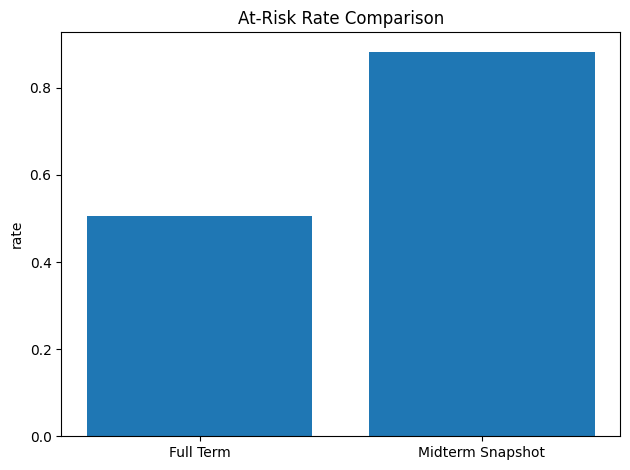

In [5]:
plt.figure()

risk_rates = [
    df_full["at_risk"].mean(),
    df_mid["at_risk"].mean()
]

plt.bar(["Full Term", "Midterm Snapshot"], risk_rates)
plt.title("At-Risk Rate Comparison")
plt.ylabel("rate")

savefig("risk_rate_comparison.png")
plt.show()


### 성취율 분포 비교 히스토그램

saved: ..\reports\figures\achievement_rate_distribution.png


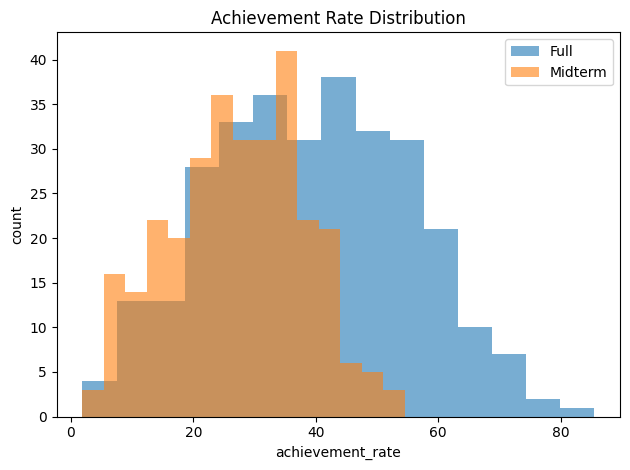

In [6]:
plt.figure()

plt.hist(df_full["achievement_rate"], bins=15, alpha=0.6, label="Full")
plt.hist(df_mid["achievement_rate"], bins=15, alpha=0.6, label="Midterm")

plt.legend()
plt.title("Achievement Rate Distribution")
plt.xlabel("achievement_rate")
plt.ylabel("count")

savefig("achievement_rate_distribution.png")
plt.show()


## 변수별 위험군 차이 분석 (핵심 EDA)

### 공통 저장 함수

In [7]:
from pathlib import Path
import matplotlib.pyplot as plt

FIG_DIR = Path("../reports/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def savefig(name: str):
    path = FIG_DIR / name
    plt.tight_layout()
    plt.savefig(path, dpi=200, bbox_inches="tight")
    print("saved:", path)

### 결석 vs 위험군

saved: ..\reports\figures\eda_absence_vs_risk.png


<Figure size 640x480 with 0 Axes>

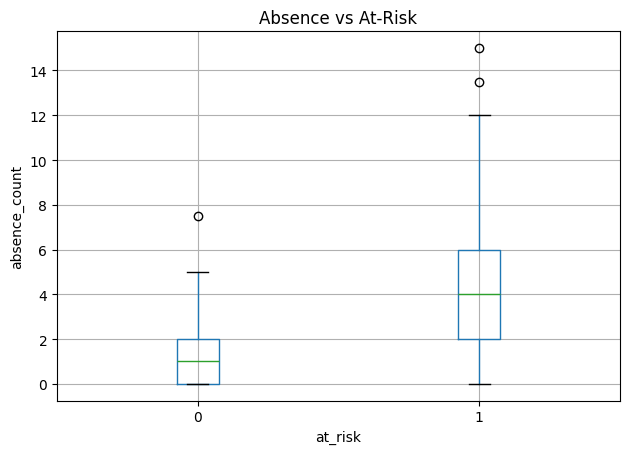

In [8]:
plt.figure()

df_mid.boxplot(column="absence_count", by="at_risk")

plt.title("Absence vs At-Risk")
plt.suptitle("")
plt.xlabel("at_risk")
plt.ylabel("absence_count")

savefig("eda_absence_vs_risk.png")
plt.show()


### 과제 제출 vs 위험군

saved: ..\reports\figures\eda_assignment_vs_risk.png


<Figure size 640x480 with 0 Axes>

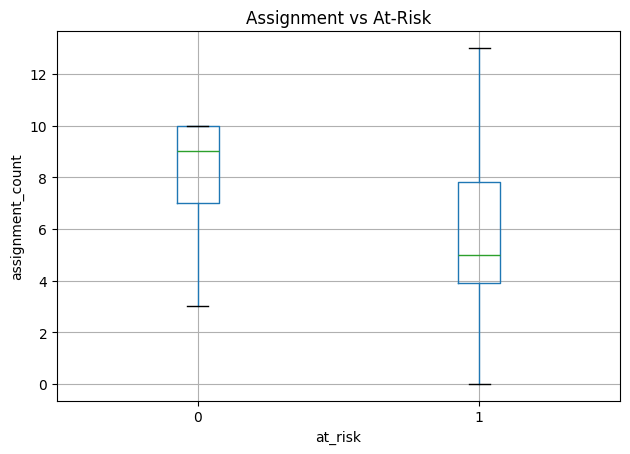

In [9]:
plt.figure()

df_mid.boxplot(column="assignment_count", by="at_risk")

plt.title("Assignment vs At-Risk")
plt.suptitle("")
plt.xlabel("at_risk")
plt.ylabel("assignment_count")

savefig("eda_assignment_vs_risk.png")
plt.show()


### 수행평가 vs 위험군

saved: ..\reports\figures\eda_performance_vs_risk.png


<Figure size 640x480 with 0 Axes>

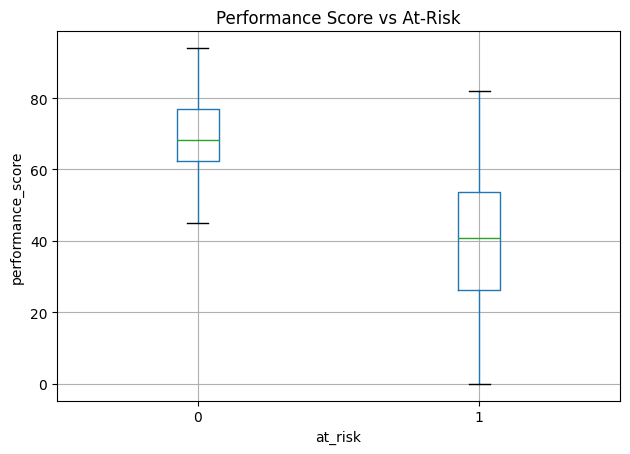

In [10]:
plt.figure()

df_mid.boxplot(column="performance_score", by="at_risk")

plt.title("Performance Score vs At-Risk")
plt.suptitle("")
plt.xlabel("at_risk")
plt.ylabel("performance_score")

savefig("eda_performance_vs_risk.png")
plt.show()

### 참여도(범주형) vs 위험군

saved: ..\reports\figures\eda_participation_vs_risk.png


C:\Users\yhs06\AppData\Local\Temp\ipykernel_23936\3917725238.py:9: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yhs06\AppData\Local\Temp\ipykernel_23936\3917725238.py:9: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yhs06\AppData\Local\Temp\ipykernel_23936\3917725238.py:9: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yhs06\AppData\Local\Temp\ipykernel_23936\3917725238.py:10: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(path, dpi=200, bbox_inches="tight")
C:\Users\yhs06\AppData\Local\Temp\ipykernel_23936\3917725238.py:10: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  plt.savefig(path, dpi=200, bbox_inches="tight")
C:\Users\yhs06\AppData\Local\Temp\ipykernel_23936\3917725238.py:10: User

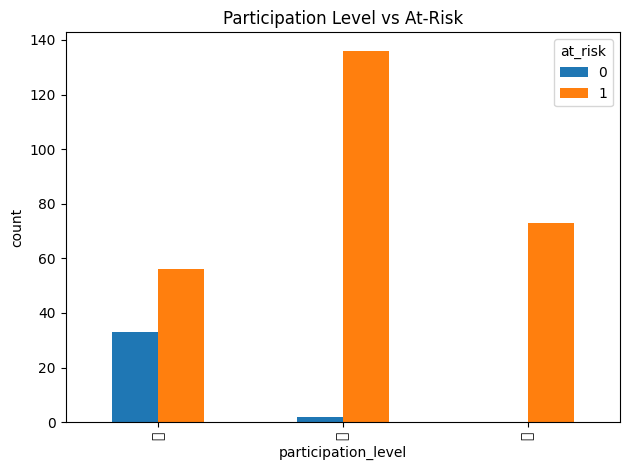

In [11]:
participation_risk = (
    df_mid.groupby(["participation_level","at_risk"])
        .size()
        .unstack(fill_value=0)
)

participation_risk.plot(kind="bar")

plt.title("Participation Level vs At-Risk")
plt.ylabel("count")

savefig("eda_participation_vs_risk.png")
plt.show()


# 결론 — 위험군 조기 탐지 기준 도출

본 EDA는 정보·컴퓨터 교과에서 최소성취수준 보장지도 대상 학생을  
학기 중간 시점에 사전 예측하기 위한 베이스라인 분석을 목적으로 수행되었다.

---

## 1. 주요 발견점

분석 결과, 위험군(at_risk=1) 학생은 다음 특성을 보였다.

- 결석 횟수가 상대적으로 높음
- 과제 제출 횟수가 낮음
- 수행평가 점수가 낮음
- 수업 참여도가 낮은 비율이 높음

이는 성취율이 확정되기 이전에도  
행동 및 과정 중심 지표만으로 위험군 탐지가 가능함을 시사한다.

---

## 2. 예비군 선별 기준 후보

학기 중간 시점에서 활용 가능한 선별 기준 후보는 다음과 같다.

1. 결석 횟수 상위 집단
2. 과제 제출 횟수 하위 집단
3. 수행평가 점수 하위 집단
4. 참여도 ‘하’ 비율이 높은 집단

해당 지표를 조합하면  
최성보 대상 예비군을 사전에 선별할 수 있다.

---

## 3. 현장 적용 시나리오

1. 교사가 학기 중간 CSV 업로드
2. 전처리 및 성취율 예측 수행
3. 위험군 리스트 자동 출력
4. 예방지도 대상 우선 선별

이를 통해 예방지도 효율성과 교사 업무 부담을 동시에 개선할 수 있다.

---

## 4. 다음 단계

본 EDA 결과를 기반으로 다음을 수행한다.

- 위험군 분류 모델 구축
- 예측 정확도 평가
- 선별 자동화 파이프라인 구현